# Crunchbase Funding Prediction Project: Data Wrangling

## Data Wrangling

The data wrangling process was quite extensive as we needed to accumulate all of the data into features which could be used to train my Random Forest and Gradient Boosting model.  This involved transforming all non-numeric data to numeric features as well as filling in missing values and creating new features to help summarize the data more effectively.

### Basic Wrangling Steps
1. Create format of dataframe with IDs, Dates, etc
2. Add or summarize numeric values and add to dataframe
3. Text variables as dummies, summarized, or vectorized
4. Export Processed Data

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
import datetime

## Original Data:

The data that will be used in this data wrangling section has been cleaned in the previous data cleaning section of the project. We will worry less about filling in empty values and converting data types and more about taking the following datasets and summarizing them into a single data frame which contains features from each section and a final target variable to use in our model.

#### Data Sections
- Companies
- Investment Rounds
- IPOs
- Acquisitions
- Organizations
- People

In [533]:
'''Crunchbase Data'''

#Information about companies.
companies = pd.read_csv('data/clean/companies.csv')

#Information about investments
investment_rounds = pd.read_csv('data/interim/investment_rounds.csv')

#Information specific to acquisitions
acquisitions = pd.read_csv('data/clean/acquisitions.csv')
ipos = pd.read_csv('data/clean/ipo.csv').drop(columns=['Unnamed: 0'])

#All organizations: Companies, Investors, Schools
organizations = pd.read_csv('data/clean/organizations.csv')

#All people: Investors (Seed, Angel, VCs, etc...)
people = pd.read_csv('data/clean/people.csv')

In [534]:
#Get rid of unnecessary warning.
pd.options.mode.chained_assignment = None # default='warn'

In [535]:
'''Simple clean up of datatypes'''
# Company Datetimes
companies['founded_at'] = pd.to_datetime(companies.founded_at, errors='coerce')
companies['first_funding_at'] = pd.to_datetime(companies.first_funding_at, errors='coerce')
companies['last_funding_at'] = pd.to_datetime(companies.last_funding_at, errors='coerce')

# Investment Rounds Datetimes
investment_rounds['funded_at'] = pd.to_datetime(investment_rounds.funded_at, errors='coerce')

# Acquisitions Datetimes
acquisitions['acquired_at'] = pd.to_datetime(acquisitions.acquired_at, errors='coerce')

# IPOs Datetimes
ipos['public_at'] = pd.to_datetime(ipos.public_at, errors='coerce')
ipos['created_at'] = pd.to_datetime(ipos.created_at, errors='coerce')
ipos['updated_at'] = pd.to_datetime(ipos.updated_at, errors='coerce')

## Processed Dataset
Using the data we want to create a single final dataframe with features that will summarize relevant information.  As we want to predict whether a startup will be funded in a given time each row will represent a quarter of a specific company after the first round of funding.  The target variable will note whether that company raised a round in the preceding year. 

As we are planning to use a Random Forest Classifier for this model we will need to represent all non-numeric variables as numeric variables.  The random forest is able to ignore noise from less important features but we will do our best to minimize the number of features as we want to be as computationally efficient as possible.

The wrangling section is broken up in the same way as the dataset themselves and pull key features from each dataset summarizing them in the format we decided on for the final table.  An additional section was added as well which was Macro variables as we want to see how the market as a whole is performing as we predict this has an impact on funding.

### Summary of Final Dataset
- Features
    - Company Data
    - Investment Round Data
    - Investor Data
    - Macro Data
- Target
    - Round Raised In the Next Month

## Master Data Frame
### Each row represents one fiscal quarter.

For this case we will build our dataframe with each row representing a fiscal quarter of a company.<br>
Our master dataframe will structure the the dataframe and contains the following 3 elements:
- Company ID & Permalink
- Quarter & Year
- Tenure Quarters Overall & Round

Building the Master Data 
1. Founding to First Funding Round
2. Rounds
3. Combine two dataframes

In [536]:
master_data = companies[['permalink','founded_at','first_funding_at','last_funding_at']].drop_duplicates().copy()
master_data.columns = ['company_permalink','founded_at','first_funding_at','last_funding_at']
master_data.shape

(66368, 4)

In [537]:
def get_start_date(row):
    if row.founded_at > row.first_funding_at:
        return row.first_funding_at
    else:
        return row.founded_at

In [538]:
master_data['start_date'] = master_data.apply(get_start_date, axis=1)
master_data['end_date'] = datetime.datetime(2015, 12, 1)

In [539]:
#Get rid of an outlier
investment_rounds = investment_rounds[investment_rounds.funded_at != investment_rounds.funded_at.min()]

In [540]:
investment_rounds.shape

(212809, 19)

In [541]:
#Clean date and select important columns
investment_rounds['funded_at'] = pd.to_datetime(investment_rounds.funded_at, format='%Y-%m-%d', errors='coerce')
round_data = investment_rounds[['company_permalink','funding_round_permalink','funded_at']].drop_duplicates()

In [542]:
# funded dates accumulated
company_round_dates = pd.DataFrame(round_data.groupby('company_permalink')['funded_at'].apply(list)).reset_index()
company_round_dates.columns = ['company_permalink','all_fund_dates']

#Merge 
round_data = pd.merge(round_data, company_round_dates)

In [543]:
round_data.shape

(114949, 4)

### Next Round Date or End of Data

In [544]:
def next_round(row):
    fund_date_list = sorted(row.all_fund_dates)
    round_fund_date = row.funded_at
    if fund_date_list.index(round_fund_date) != (len(fund_date_list) - 1):
        return fund_date_list[fund_date_list.index(round_fund_date) + 1]
    else:
        return pd.to_datetime('2015-12-1', format='%Y-%m-%d', errors='coerce')

In [545]:
#
round_data['next_fund_date'] = round_data.apply(next_round, axis=1)

In [546]:
round_data.head()

,company_permalink,funding_round_permalink,funded_at,all_fund_dates,next_fund_date
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,2008-03-19,[2008-03-19 00:00:00],2015-12-01
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,2014-07-24,[2014-07-24 00:00:00],2015-12-01
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,2014-07-01,[2014-07-01 00:00:00],2015-12-01
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,2015-11-09,"[2015-11-09 00:00:00, 2013-05-22 00:00:00, 201...",2015-12-01
4,/organization/0xdata,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,2013-05-22,"[2015-11-09 00:00:00, 2013-05-22 00:00:00, 201...",2014-07-19


### Months between rounds

In [547]:
from dateutil.relativedelta import relativedelta
def months_between_rounds(row):
    """Gets a list of all month dates between rounds"""
    funded = row.funded_at
    next_funded = row.next_fund_date
    dates = []
    cur_date = funded
    
    while cur_date < next_funded:
        dates.append(cur_date)
        cur_date += relativedelta(months=1)
    return dates

In [548]:
# 
round_data['dates'] = round_data.apply(months_between_rounds, axis=1)

In [549]:
# 
funding_full_data = pd.DataFrame(round_data['dates'].values.tolist()).merge(features.reset_index(drop=True), right_index=True, left_index=True)\
                            .melt(id_vars=features.columns).dropna()

In [550]:
# 
funding_full_data = funding_full_data.dropna().drop_duplicates()
funding_full_data.shape

(3502081, 6)

### Year and Quarter

In [551]:
funding_full_data['date'] = funding_full_data['value']
funding_full_data['year'] = funding_full_data['value'].dt.year
funding_full_data['month'] = funding_full_data['value'].dt.month
funding_full_data = funding_full_data.drop_duplicates(subset=['company_permalink','year','month'])

In [552]:
def month_to_quarter(value):
    if value < 4:
        return 1
    elif value < 7:
        return 2
    elif value < 10:
        return 3
    else:
        return 4

In [553]:
# months to quarters
funding_full_data['quarter'] = funding_full_data['month'].apply(month_to_quarter)

### Round Tenure (Quarters )

In [554]:
# Get Quarter from months data
funding_full_data['tenure_quarters_round'] = (funding_full_data['variable'] / 3).astype(int)

# reduce to show by quarter
funding_full_quarters = funding_full_data.drop(columns=['value','variable','month']).drop_duplicates()

#Sort 
full_quarter_data = funding_full_quarters.groupby(['company_permalink','year','quarter'])['tenure_quarters_round'].max().reset_index()

In [555]:
# 
round_quarter_data = full_quarter_data.merge(funding_full_quarters[['company_permalink','year','quarter','funding_round_permalink','date']])
round_quarter_data = round_quarter_data.drop_duplicates(subset=['company_permalink','year','quarter','tenure_quarters_round'])

### Overall Company Tenure (Quarters)

In [556]:
# Get all quarter dates for each company
company_date_lists = pd.DataFrame(round_quarter_data.groupby('company_permalink')['date'].apply(list)).reset_index()
company_date_lists.columns = ['company_permalink','dates']

In [557]:
#Merge to dataframe
round_quarter_data = round_quarter_data.merge(company_date_lists)

In [558]:
def overall_tenure(row):
    all_dates = row.dates
    quarter_date = row.date
    tenure = all_dates.index(quarter_date)
    return tenure

In [559]:
#
round_quarter_data['tenure_quarters_overall'] = round_quarter_data.apply(overall_tenure, axis=1)

In [560]:
# Create Master Data Table
master_cols = ['company_permalink','funding_round_permalink','year','quarter',\
               'tenure_quarters_overall','tenure_quarters_round']
master_data = round_quarter_data[master_cols].drop_duplicates()

In [561]:
master_data.shape

(1203049, 6)

### Add Company IDs

In [562]:
company_ids = master_data[['company_permalink']].drop_duplicates().reset_index(drop=True).reset_index()
company_ids.columns = ['company_id','company_permalink']

In [563]:
master_data = company_ids.merge(master_data, how='right')

In [564]:
master_data.shape

(1203049, 7)

In [565]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203049 entries, 0 to 1203048
Data columns (total 7 columns):
company_id                 1203049 non-null int64
company_permalink          1203049 non-null object
funding_round_permalink    1203049 non-null object
year                       1203049 non-null int64
quarter                    1203049 non-null int64
tenure_quarters_overall    1203049 non-null int64
tenure_quarters_round      1203049 non-null int64
dtypes: int64(5), object(2)
memory usage: 73.4+ MB


In [566]:
master_data.head(10)

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1
2,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,3,2,2
3,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,4,3,3
4,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,1,0,0
5,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,2,1,1
6,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,3,2,2
7,1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,2014,4,3,0
8,1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,2015,1,4,1
9,1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,2015,2,5,2


# Lets start adding features!

# 1. Company Data
#### Things to remember
- Each row is a quarter of a company
- Features we will pull from company data.
    - Country
    - Founded At
    - First Funding
    - Founding to First Funding.
- Feature from Organizations Data  
    - Short Description

### Explore Companies Data

In [567]:
companies.head(2)

,Unnamed: 0,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaT,2015-01-05,2015-01-05
1,1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14


In [568]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 15 columns):
Unnamed: 0           66368 non-null int64
permalink            66368 non-null object
name                 66367 non-null object
homepage_url         61310 non-null object
category_list        63220 non-null object
funding_total_usd    66368 non-null object
status               66368 non-null object
country_code         59410 non-null object
state_code           57821 non-null object
region               58338 non-null object
city                 58340 non-null object
funding_rounds       66368 non-null int64
founded_at           51143 non-null datetime64[ns]
first_funding_at     66341 non-null datetime64[ns]
last_funding_at      66368 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(10)
memory usage: 7.6+ MB


### Clean

In [569]:
company_data = companies[['permalink','founded_at','first_funding_at']]
company_data.columns = ['company_permalink','founded_at','first_funding_at']

### a) Company Descriptions
We will not do too much processing here but this will be preprocessed as bag of words in the machine learning section.

In [570]:
def url_to_permalink(row):
    '''Formats permalink in same way as other datasets'''
    return row.crunchbase_url.split('https://www.crunchbase.com')[1].split('?')[0]

In [571]:
# Sets Permalink applying the previous function
organizations['company_permalink'] = organizations.dropna(subset=['crunchbase_url']).apply(url_to_permalink, axis=1)

In [572]:
# Display Result
organizations[['company_permalink','short_description']].head()

,company_permalink,short_description
0,/organization/wetpaint,Wetpaint offers an online social publishing pl...
1,/organization/zoho,"Zoho offers a suite of business, collaboration..."
2,/organization/digg,Digg Inc. operates a website that enables its ...
3,/organization/facebook,Facebook is an online social networking servic...
4,/organization/omnidrive,Omnidrive provides online storage facilities t...


In [573]:
# Add Description column to the company_data dataset
company_data = company_data.merge(organizations[['company_permalink','short_description']], how='left')

### b) Categories
This will also be added to the bag-of-words section in machine learning.

In [574]:
# Add Category column to the company_data dataset
company_data = company_data.merge(investment_rounds[['company_permalink','company_category_list']].drop_duplicates(), how='left')

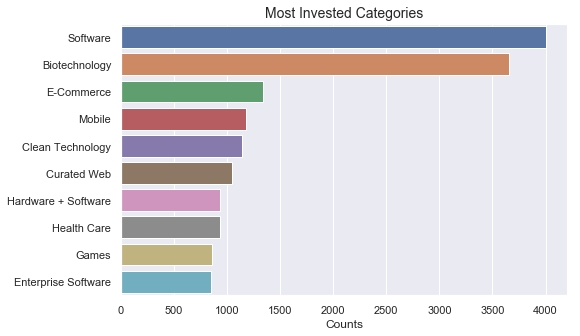

In [575]:
category_counts = pd.DataFrame(company_data.company_category_list.value_counts()).reset_index()
category_counts.columns = ['category','count']

#Plot
_ = plt.figure(figsize=(8,5))
_ = sns.barplot(x='count', y='category', data=category_counts.head(10))
_ = plt.title('Most Invested Categories', size=14)
_ = plt.xlabel('Counts')
_ = plt.ylabel('')

### c) Category Count

In [576]:
#Break up grouped up categories into list.  EX. "Apps|Cable|Distribution|Software"
def breakup_categories(row):
    if type(row.company_category_list) == str:
        category_list = row.company_category_list.split('|')
        return category_list
    else:
        return str(row.company_category_list)

In [577]:
# Count Categories
investment_rounds['company_category_count'] = investment_rounds.apply(breakup_categories, axis=1).apply(len)

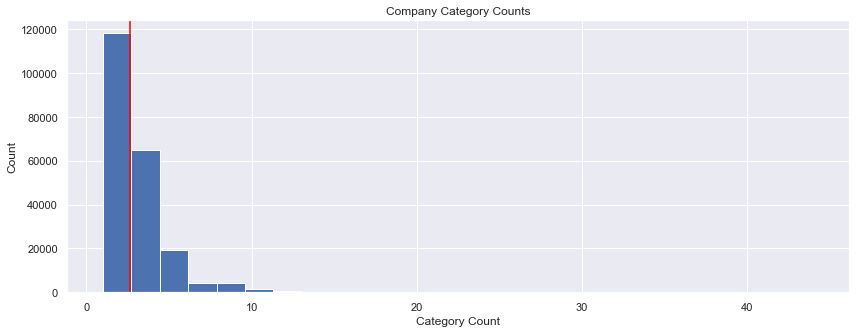

In [578]:
_ = plt.figure(figsize=(14,5))
_ = plt.hist(investment_rounds['company_category_count'], bins=25)
_ = plt.axvline(np.mean(investment_rounds['company_category_count']), color='red')
_ = plt.title('Company Category Counts')
_ = plt.xlabel('Category Count')
_ = plt.ylabel('Count')

In [579]:
# Add Category count to the company_data dataset
company_data = company_data.merge(investment_rounds[['company_permalink','company_category_count']].drop_duplicates(), how='left')

### d) Founding to First Funding

In [580]:
# FIll missing Founding Values
company_missing_founding = company_data[company_data.founded_at.isnull()]
company_missing_founding['founded_at'] = company_missing_founding.first_funding_at - np.timedelta64(36, 'M')
company_missing_founding['founding_to_funding_months'] = 36

In [581]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66516 entries, 0 to 66515
Data columns (total 6 columns):
company_permalink         66516 non-null object
founded_at                51253 non-null datetime64[ns]
first_funding_at          66489 non-null datetime64[ns]
short_description         60354 non-null object
company_category_list     63367 non-null object
company_category_count    66516 non-null int64
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 3.6+ MB


In [582]:
# Drop founding at for empty numbers as there are very few
company_data = company_data.dropna(subset=['founded_at'])

In [583]:
# Subtract first funding and founding date and divide by timedelta to get months between.
company_data['founding_to_funding_months'] = (company_data['first_funding_at'] - company_data['founded_at']) // np.timedelta64(1, 'M')

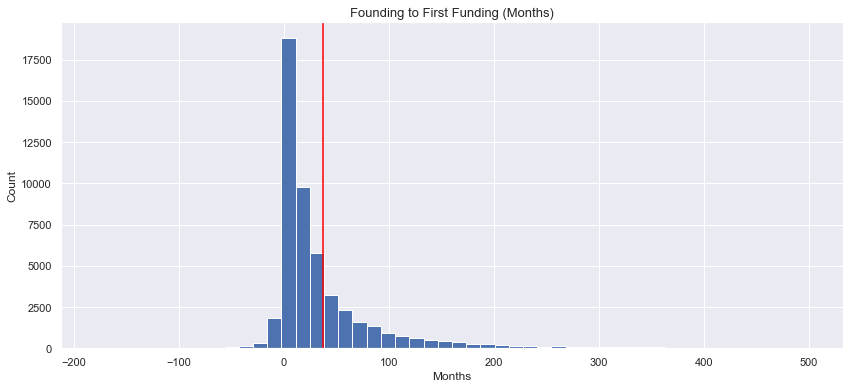

In [584]:
# Get rid of outliers above 500 and below 200 months
founding_to_first_funding_ot = company_data[(company_data['founding_to_funding_months'] < 500) & (company_data['founding_to_funding_months'] > -200)]

# Plot
_ = plt.figure(figsize=(14,6))
_ = founding_to_first_funding_ot['founding_to_funding_months'].hist(bins=50)
_ = plt.axvline(np.mean(founding_to_first_funding_ot['founding_to_funding_months']), color='red')
_ = plt.title('Founding to First Funding (Months)', size=13)
_ = plt.xlabel('Months')
_ = plt.ylabel('Count')

In [585]:
# Merge Filled Values with 
company_data = pd.concat([company_missing_founding, company_data])

In [586]:
company_data.head(2)

,company_permalink,founded_at,first_funding_at,short_description,company_category_list,company_category_count,founding_to_funding_months
0,/organization/-fame,2012-01-05 06:32:24,2015-01-05,Fame is a live video entertainment platform th...,Media,1,36.0
2,/organization/-the-one-of-them-inc-,2011-01-30 06:32:24,2014-01-30,"ONE of THEM, Inc. is an online platform that o...",Apps|Games|Mobile,3,36.0


### e) Datetimes to Year and Months

In [587]:
#Founding datetimes to ints
company_data['founded_yr'] = company_data['founded_at'].dt.year
company_data['founded_month'] = company_data['founded_at'].dt.month

#First funding datetimes to ints
company_data['first_funding_yr'] = company_data['first_funding_at'].dt.year
company_data['first_funding_month'] = company_data['first_funding_at'].dt.month

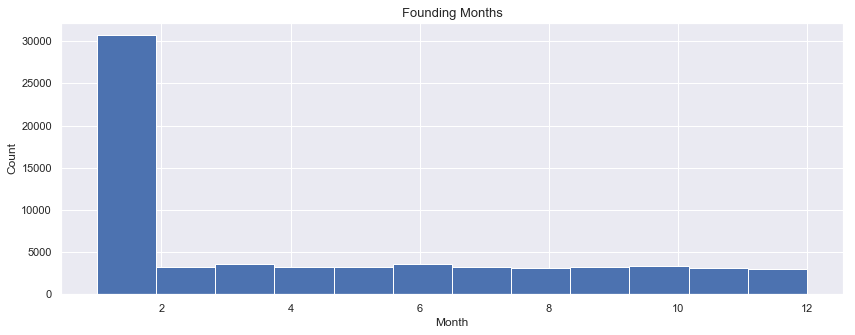

In [588]:
_ = plt.figure(figsize=(14,5))
_ = company_data['founded_month'].hist(bins=12)
_ = plt.title('Founding Months', size=13)
_ = plt.xlabel('Month')
_ = plt.ylabel('Count')

### Founding & First Fundings Over Time

In [589]:
first_funding_over_time = company_data.groupby('first_funding_yr')[['company_permalink']].count().reset_index()
first_funding_over_time.columns = ['year','first_funding_count']

foundings_over_time = company_data.groupby('founded_yr')[['company_permalink']].count().reset_index()
foundings_over_time.columns = ['year','founding_count']

founding_and_funding = pd.merge(foundings_over_time, first_funding_over_time)
founding_and_funding = founding_and_funding.set_index('year')

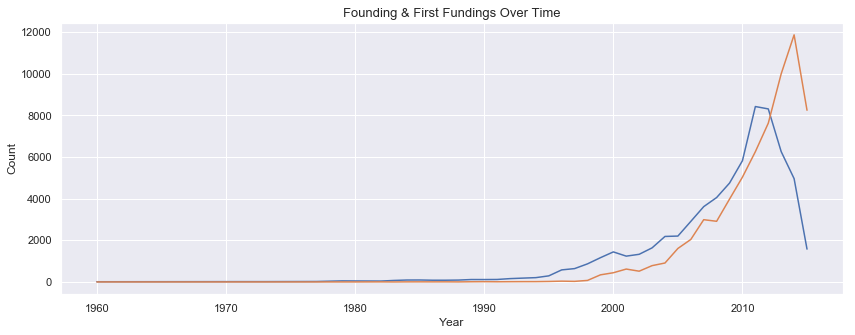

In [590]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(founding_and_funding)
_ = plt.title('Founding & First Fundings Over Time', size=13)
_ = plt.xlabel('Year')
_ = plt.ylabel('Count')

## Final Company Data

In [591]:
#Drop Redundant Columns
final_company_data = master_data.merge(company_data.drop(columns=['founded_at','first_funding_at']).drop_duplicates())

In [592]:
final_company_data.shape

(1203045, 15)

In [593]:
final_company_data.head(2)

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round,short_description,company_category_list,company_category_count,founding_to_funding_months,founded_yr,founded_month,first_funding_yr,first_funding_month
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0,Fame is a live video entertainment platform th...,Media,1,36.0,2012.0,1.0,2015.0,1.0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1,Fame is a live video entertainment platform th...,Media,1,36.0,2012.0,1.0,2015.0,1.0


In [594]:
final_company_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203045 entries, 0 to 1203044
Data columns (total 15 columns):
company_id                    1203045 non-null int64
company_permalink             1203045 non-null object
funding_round_permalink       1203045 non-null object
year                          1203045 non-null int64
quarter                       1203045 non-null int64
tenure_quarters_overall       1203045 non-null int64
tenure_quarters_round         1203045 non-null int64
short_description             1072375 non-null object
company_category_list         1142271 non-null object
company_category_count        1203045 non-null int64
founding_to_funding_months    1202845 non-null float64
founded_yr                    1203027 non-null float64
founded_month                 1203027 non-null float64
first_funding_yr              1202827 non-null float64
first_funding_month           1202827 non-null float64
dtypes: float64(5), int64(6), object(4)
memory usage: 146.9+ MB


# 2. Investment Round Data
With the investment round data we can start adding features that relate specifically to each row (round). This includes information about investors info and funding data, however, to keep things organized we will have another section specifically for investor information and stick to funding data for this section.

#### Key Features in Investment Rounds:
    - Funding Round Number
    - Funding Type
    - Funding Code
    - Funding Round Amount
    - Previous Round Type
    - Previous Round Code
    - Previous Round Length
    - Previous Round Amount
    - Funding Total To Date

In [595]:
master_data.head()

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1
2,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,3,2,2
3,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,4,3,3
4,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,1,0,0


In [780]:
#Clean date and select important columns
investment_rounds['funded_at'] = pd.to_datetime(investment_rounds.funded_at, format='%Y-%m-%d', errors='coerce')
round_data = investment_rounds[['company_permalink','funding_round_permalink','funding_round_type','funding_round_code','funded_at','raised_amount_usd']].drop_duplicates()

In [781]:
#Merge company founding data
round_data = round_data.merge(company_data[['company_permalink','founded_at']].drop_duplicates())

In [782]:
round_data.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,founded_at
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,2007-01-01 00:00:00
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,NaN,2010-01-01 00:00:00
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,41250.0,2011-07-01 06:32:24
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,2011-01-01 00:00:00
4,/organization/0xdata,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,2011-01-01 00:00:00


### a) Round Number

In [783]:
def round_number(row):
    fund_date_list = sorted(row.all_fund_dates)
    round_fund_date = row.funded_at
    return fund_date_list.index(round_fund_date) + 1

In [784]:
# funded dates accumulated
company_round_dates = pd.DataFrame(round_data.groupby('company_permalink')['funded_at'].apply(list)).reset_index()
company_round_dates.columns = ['company_permalink','all_fund_dates']

# Merge with Data
round_data = pd.merge(round_data, company_round_dates)

# Apply
round_data['round_number'] = round_data.apply(round_number, axis=1)

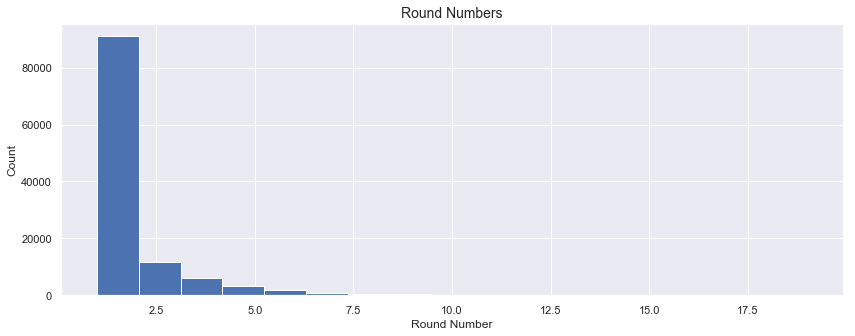

In [785]:
_ = plt.figure(figsize=(14,5))
_ = round_data['round_number'].hist(bins=17)
_ = plt.title('Round Numbers', size=14)
_ = plt.xlabel('Round Number')
_ = plt.ylabel('Count')

### b) Raised Amount USD

In [786]:
# Get Null Values
has_amount_raised = round_data[round_data.raised_amount_usd.notnull()]
need_amount_raised = round_data[round_data.raised_amount_usd.isnull()]

In [787]:
# Get Averages for each round, funding type & code.
average_amounts = round_data.groupby(['round_number','funding_round_type','funding_round_code']).mean().reset_index()

In [788]:
# Fill with mean of round number
amount_raised_filled = need_amount_raised.drop(columns=['raised_amount_usd']).merge(average_amounts, how='left')[need_amount_raised.columns]

In [789]:
# Combine for full set
round_data = pd.concat([has_amount_raised, amount_raised_filled])

### Overall Raise Amount Distribution

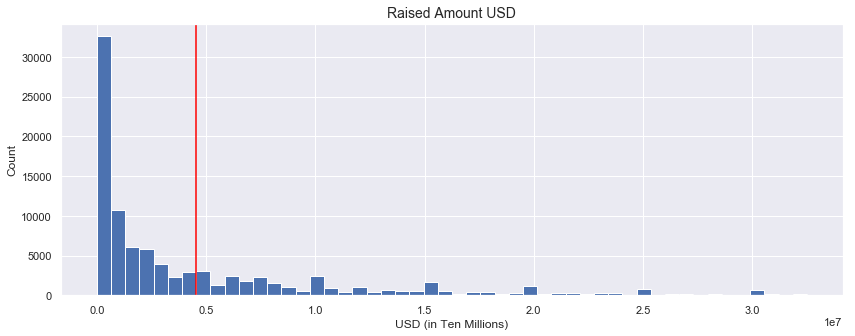

In [790]:
# Only use data in the 95-percentile of the raised amount.
no_outliers_raised = round_data[round_data['raised_amount_usd'] <= round_data['raised_amount_usd'].quantile(0.95)]

# Plot
_ = plt.figure(figsize=(14,5))
_ = no_outliers_raised['raised_amount_usd'].hist(bins=50)
_ = plt.axvline(np.mean(no_outliers_raised['raised_amount_usd']), color='red')
_ = plt.title('Raised Amount USD', size=14)
_ = plt.xlabel('USD (in Ten Millions)')
_ = plt.ylabel('Count')

### b) Total Funding to Date

In [791]:
def total_fund_to_date(row):
    
    sorted_dates, sorted_amounts = zip(*sorted(zip(row.all_fund_dates, row.all_fund_amounts)))
    
    total_fund = 0
    for i in range(sorted_dates.index(row.funded_at) + 1):
        total_fund += sorted_amounts[i]

    return total_fund

In [792]:
# Funding Data
company_round_amount = pd.DataFrame(round_data.groupby('company_permalink')['raised_amount_usd'].apply(list)).reset_index()
company_round_amount.columns = ['company_permalink','all_fund_amounts']

#Merge 
round_data = pd.merge(round_data, company_round_amount)

#Apply 
round_data['total_funding_usd'] = round_data.apply(total_fund_to_date, axis=1)

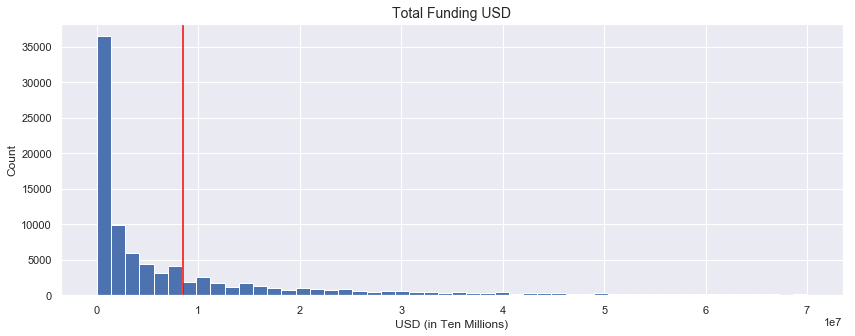

In [793]:
# 
no_outliers_ttl = round_data[round_data['total_funding_usd'] <= round_data['total_funding_usd'].quantile(0.95)]

# 
_ = plt.figure(figsize=(14,5))
_ = no_outliers_ttl['total_funding_usd'].hist(bins=50)
_ = plt.axvline(np.mean(no_outliers_ttl['total_funding_usd']), color='red')
_ = plt.title('Total Funding USD', size=14)
_ = plt.xlabel('USD (in Ten Millions)')
_ = plt.ylabel('Count')

### c) Round Type and Code

1. <strong>Mark Venture Rounds that do not have a round code identified as "Unknown" </strong>
2. <strong>For Simplicity we will combine the two columns</strong>.
    - Round Codes is specific to venture round such as A,B,C.
    - Round Types includes seed, angel, debt financing etc, with venture rounds being defined as venture.

In [794]:
def mark_unknown_venture_rounds(row):
    if (row.funding_round_type == 'venture') & (type(row.funding_round_code) != str):
        return "Unknown"
    else:
        return row.funding_round_code

In [795]:
# Fill Venture Rounds with Missing Round Codes
round_data['funding_round_code'] = round_data.apply(mark_unknown_venture_rounds, axis=1)

In [796]:
def get_round_name(row):
    if (row.funding_round_type == 'venture') & (type(row.funding_round_code) == str):
        return row.funding_round_code
    else:
        return row.funding_round_type

In [797]:
#
round_data['funding_round'] = round_data.apply(get_round_name, axis=1)

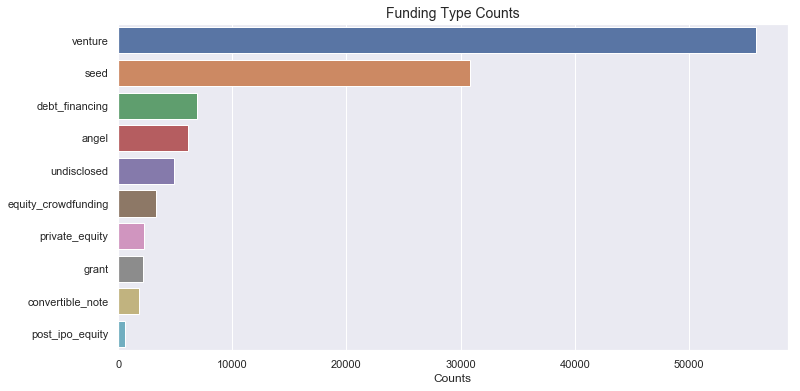

In [798]:
funding_type_counts = pd.DataFrame(round_data.funding_round_type.value_counts()).reset_index()
funding_type_counts.columns = ['category','count']

#Plot
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='count', y='category', data=funding_type_counts.head(10))
_ = plt.title('Funding Type Counts', size=14)
_ = plt.xlabel('Counts')
_ = plt.ylabel('')

### d) Previous Round Code and Type

In [799]:
previous_round_data = round_data[['company_permalink','round_number','funded_at','raised_amount_usd','funding_round_code','funding_round_type']]

In [800]:
#
previous_round_data['prev_round_number'] = previous_round_data['round_number']
previous_round_data['prev_funded_at'] = previous_round_data['funded_at']
previous_round_data['round_number'] = previous_round_data['round_number'] + 1

#
previous_round_data = previous_round_data.drop(columns=['funded_at'])

In [801]:
previous_round_data.columns = ['company_permalink','round_number','prev_raised_amount_usd',\
                               'prev_funding_round_code','prev_funding_round_type','prev_round_number',\
                               'prev_funded_at']

In [802]:
previous_round_data.head()

,company_permalink,round_number,prev_raised_amount_usd,prev_funding_round_code,prev_funding_round_type,prev_round_number,prev_funded_at
0,/organization/0-6-com,2,2000000.0,A,venture,1,2008-03-19
1,/organization/01games-technology,2,41250.0,NaN,undisclosed,1,2014-07-01
2,/organization/0xdata,5,20000000.0,B,venture,4,2015-11-09
3,/organization/0xdata,3,3000000.0,NaN,seed,2,2013-05-22
4,/organization/0xdata,2,1700000.0,Unknown,venture,1,2013-01-03


In [803]:
#
round_data = round_data.merge(previous_round_data, how='left')

In [804]:
round_data['prev_funding_round_type'] = round_data['prev_funding_round_type'].fillna('no_prev_round')
round_data['prev_round_number'] = round_data['prev_round_number'].fillna(0)
round_data['prev_raised_amount_usd'] = round_data['prev_raised_amount_usd'].fillna(0)

### Clean Funding Data

In [805]:
# Drop Redundant columns
round_data_cols = ['company_permalink','funding_round_permalink','round_number',\
                   'funding_round','funding_round_type','funding_round_code',\
                   'raised_amount_usd','total_funding_usd','prev_raised_amount_usd',\
                   'prev_round_number','prev_funding_round_type','prev_funding_round_code']

final_funding_data = round_data[round_data_cols]

In [806]:
final_funding_data.shape

(115731, 12)

In [807]:
final_funding_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115731 entries, 0 to 115730
Data columns (total 12 columns):
company_permalink          115731 non-null object
funding_round_permalink    115731 non-null object
round_number               115731 non-null int64
funding_round              115731 non-null object
funding_round_type         115731 non-null object
funding_round_code         56004 non-null object
raised_amount_usd          98709 non-null float64
total_funding_usd          93929 non-null float64
prev_raised_amount_usd     115731 non-null float64
prev_round_number          115731 non-null float64
prev_funding_round_type    115731 non-null object
prev_funding_round_code    26066 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 11.5+ MB


# 3. Investor Data

Third section will cover related information about the investors in each round.

In [624]:
#Trim down columns fro investor data
investor_data = investment_rounds[['company_permalink','funding_round_permalink','funding_round_type','funding_round_code','funded_at','raised_amount_usd']].drop_duplicates()

In [625]:
investor_data.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,NaN
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,41250.0
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0
7,/organization/0xdata,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0


In [626]:
investor_data.shape

(115732, 6)

### a) Investor and company in same country (Binary)
If there are multiple investors in a round we will say TRUE if any of the investors are the same country.

In [627]:
#Investor Company Same Country
investment_rounds['investor_company_same_country'] = (investment_rounds['company_country_code'] == investment_rounds['investor_country_code']).astype('int')

In [628]:
investment_rounds[['company_permalink','investor_company_same_country']].head()

,company_permalink,investor_company_same_country
0,/organization/0-6-com,1
1,/organization/004-technologies,0
2,/organization/01games-technology,1
3,/organization/0xdata,1
4,/organization/0xdata,1


In [629]:
# Merge investor compnay same country binary data to investor data 
investor_data = investor_data.merge(investment_rounds[['company_permalink','investor_company_same_country']].drop_duplicates(), how='left')

In [630]:
investor_data.shape

(163707, 7)

### b) Number of Investors in Round

In [631]:
#Count Number of investors in each round
round_investor_count = investment_rounds.drop_duplicates(subset=['company_permalink','investor_permalink','funding_round_permalink']).groupby(['funding_round_permalink']).count()[['investor_permalink']].reset_index()

#Change column names so they do not overlap
round_investor_count.columns = ['funding_round_permalink','round_investor_count']

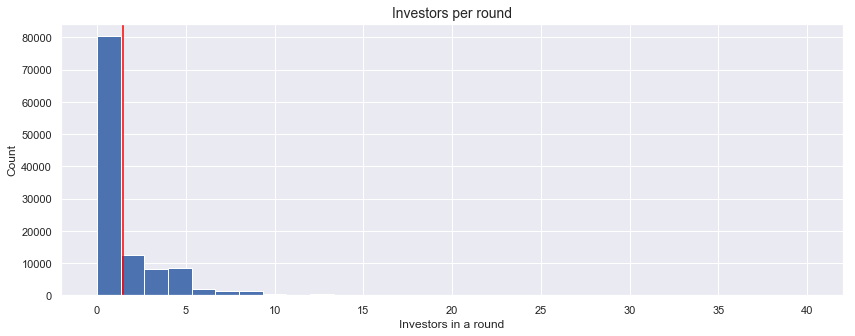

In [632]:
_ = plt.figure(figsize=(14,5))
_ = round_investor_count.round_investor_count.hist(bins=30)
_ = plt.axvline(np.mean(round_investor_count['round_investor_count']), color='red')
_ = plt.title('Investors per round', size=14)
_ = plt.xlabel('Investors in a round')
_ = plt.ylabel('Count')

In [633]:
#Merge Round Investor Count to investor data table
investor_data = investor_data.merge(round_investor_count)

In [634]:
investor_data.shape

(163707, 8)

### Investor Investments Count
Total number of investments by investors of the round.
This will hopefully help to quantify experience of the investors.

To get more accurate information from this:
- Investor Investments Total Counts
- Investor Max Invemstents Counts
- Investor Max Investments Pct


In [635]:
investor_investment_count = investment_rounds.drop_duplicates(subset=['company_permalink','investor_permalink','funding_round_permalink']).groupby(['investor_permalink'])[['funding_round_permalink']].count().reset_index()

#Change column names so they do not overlap
investor_investment_count.columns = ['investor_permalink','investor_investments_count']

In [636]:
# Merge to rounds data to associate with funding roundsa
investment_rounds = investment_rounds.merge(investor_investment_count, how='left')

### c) Investor Investments Total Counts

In [637]:
# Group investor investment count by round to get total by round.
round_investor_investment_count = investment_rounds.groupby('funding_round_permalink')[['investor_investments_count']].sum().reset_index()
round_investor_investment_count.columns = ['funding_round_permalink','investor_investments_total_count']

In [638]:
# Merge Investor investment counts data to investor data
investor_data = investor_data.merge(round_investor_investment_count)

In [639]:
investor_data.shape

(163707, 9)

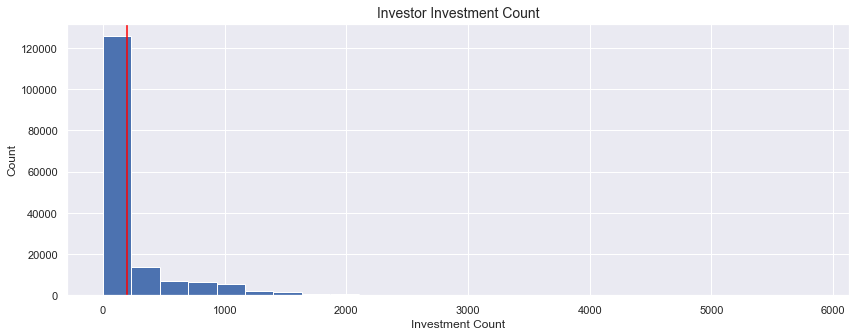

In [640]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_investments_total_count.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_investments_total_count']), color='red')
_ = plt.title('Investor Investment Count', size=14)
_ = plt.xlabel('Investment Count')
_ = plt.ylabel('Count')

### d) Investor Investment Max Count

In [641]:
# Group investor investment max by round to get total by round.
round_investor_investment_max = investment_rounds.groupby('funding_round_permalink')[['investor_investments_count']].max().reset_index()
round_investor_investment_max.columns = ['funding_round_permalink','investor_investments_max_count']

In [642]:
# Merge Investor investment max counts data to investor data
investor_data = investor_data.merge(round_investor_investment_max)

In [643]:
investor_data.shape

(163707, 10)

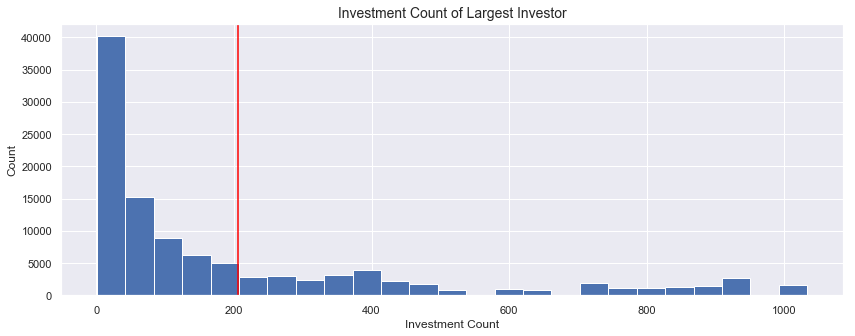

In [644]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_investments_max_count.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_investments_max_count']), color='red')
_ = plt.title('Investment Count of Largest Investor', size=14)
_ = plt.xlabel('Investment Count')
_ = plt.ylabel('Count')

### e) Investor Investment Max Pct

In [645]:
# Calcualte Percent of Total counts that max investor count is.
investor_data['investor_investments_max_pct'] = investor_data['investor_investments_max_count'] / investor_data['investor_investments_total_count']

In [646]:
investor_data[['company_permalink','funding_round_permalink','investor_investments_total_count','investor_investments_max_count','investor_investments_max_pct']].head(3)

,company_permalink,funding_round_permalink,investor_investments_total_count,investor_investments_max_count,investor_investments_max_pct
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,16.0,16.0,1.0
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,8.0,8.0,1.0
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,167.0,167.0,1.0


In [647]:
investor_data.shape

(163707, 11)

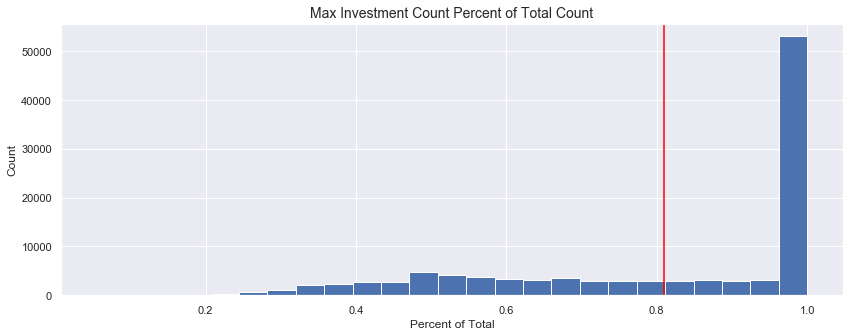

In [648]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_investments_max_pct.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_investments_max_pct']), color='red')
_ = plt.title('Max Investment Count Percent of Total Count', size=14)
_ = plt.xlabel('Percent of Total')
_ = plt.ylabel('Count')

### Investor Exits
Count total number of exits by an investor (Person/Organization).<br>
To account for multple investors in a round:
- Total Investor exit count
- Max Investor exit
- Max Investor exits percent (Percent of total exits by biggest investor)

In [649]:
companies[['permalink','status']].head()

,permalink,status
0,/organization/-fame,operating
1,/organization/-qounter,operating
2,/organization/-the-one-of-them-inc-,operating
3,/organization/0-6-com,operating
4,/organization/004-technologies,operating


In [650]:
#merge company status data to investment round data
investment_rounds = investment_rounds.merge(companies[['permalink','status']], left_on='company_permalink', right_on='permalink', how='left').drop(columns=['permalink'])

In [651]:
investment_rounds.shape

(212809, 23)

In [652]:
investment_rounds.head(3)

,Unnamed: 0,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,...,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,company_category_count,investor_company_same_country,investor_investments_count,status
0,0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,...,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,1,1,16.0,operating
1,1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,...,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,NaN,1,0,8.0,operating
2,2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,...,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,41250.0,1,1,167.0,operating


### f) Total Investor Exit Count

In [653]:
# Count Investor Exits
investor_exit_count = investment_rounds[(investment_rounds.status == 'ipo') | (investment_rounds.status == 'acquired')].groupby(['investor_permalink'])[['company_permalink']].count().reset_index()
investor_exit_count.columns = ['investor_permalink','investor_exits_count']

#Merge to investment rounds to get investors by round
investment_rounds = investment_rounds.merge(investor_exit_count, how='left')
investment_rounds.shape

(212809, 24)

In [654]:
#Group by Round to get Total Investor Exit Count
investor_total_exit_count = investment_rounds.groupby(['funding_round_permalink'])[['investor_exits_count']].sum().reset_index()
investor_total_exit_count.columns = ['funding_round_permalink','investor_exits_total_count']

#Merge investor total exit count to investor data
investor_data = investor_data.merge(investor_total_exit_count, how='left')
investor_data.shape

(163707, 12)

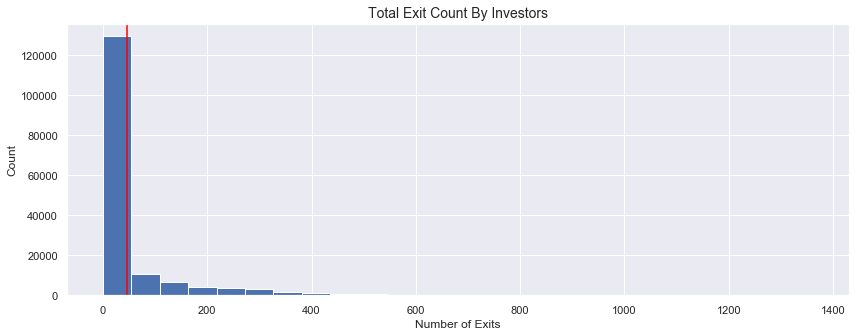

In [655]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_exits_total_count.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_exits_total_count']), color='red')
_ = plt.title('Total Exit Count By Investors', size=14)
_ = plt.xlabel('Number of Exits')
_ = plt.ylabel('Count')

### g) Total Investor Exit Max Count

In [656]:
#Group by Round to get Total Investor Exit Count
investor_max_exit_count = investment_rounds.groupby(['funding_round_permalink'])[['investor_exits_count']].max().reset_index()
investor_max_exit_count.columns = ['funding_round_permalink','investor_exits_max_count']

#Merge investor max exit count to investor data
investor_data = investor_data.merge(investor_max_exit_count, how='left')
investor_data.shape

(163707, 13)

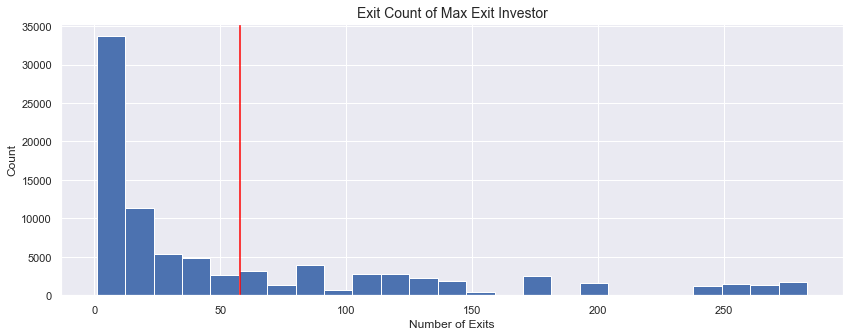

In [657]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_exits_max_count.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_exits_max_count']), color='red')
_ = plt.title('Exit Count of Max Exit Investor', size=14)
_ = plt.xlabel('Number of Exits')
_ = plt.ylabel('Count')

### h) Total Investor Exit Max Percent

In [658]:
# Calculate Percent of Total Count of Max Count Investor
investor_data['investor_exits_max_pct'] = investor_data['investor_exits_max_count'] / investor_data['investor_exits_total_count']
investor_data.shape

(163707, 14)

In [659]:
investor_data[['company_permalink','funding_round_permalink','investor_exits_total_count','investor_exits_max_count','investor_exits_max_pct']].drop_duplicates().head(3)

,company_permalink,funding_round_permalink,investor_exits_total_count,investor_exits_max_count,investor_exits_max_pct
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,2.0,2.0,1.0
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,2.0,2.0,1.0
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,0.0,NaN,NaN


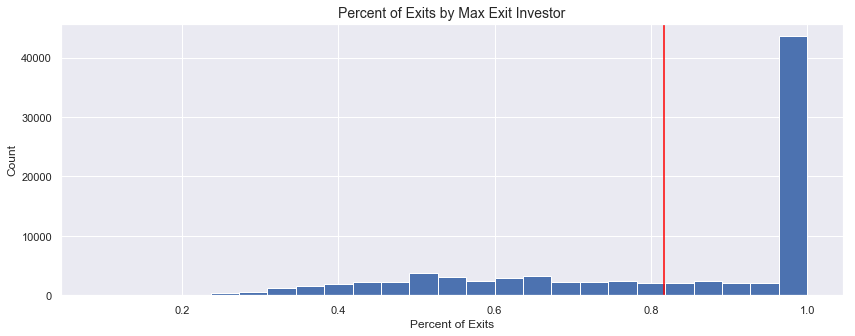

In [660]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_exits_max_pct.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_exits_max_pct']), color='red')
_ = plt.title('Percent of Exits by Max Exit Investor', size=14)
_ = plt.xlabel('Percent of Exits')
_ = plt.ylabel('Count')

### Number of Industry Investments by Investors
For better understanding of the investor industry investments per round:
- Investor Industry Investments Total Count
- Investor Industry Investments Max Count
- Investor Industry Investments Max Percentage (Max/Total)

In [661]:
#Break up grouped up categories into list.  EX. "Apps|Cable|Distribution|Software"
def breakup_categories(row):
    if type(row.company_category_list) == str:
        category_list = row.company_category_list.split('|')
        return category_list
    else:
        return str(row.company_category_list)

In [662]:
#Inndustry Investment count by investor.
industry_investment_count = investment_rounds[['company_permalink','investor_permalink','funding_round_permalink','company_category_list']].drop_duplicates()

In [663]:
# Separate multi category variables vertically
company_category_data = industry_investment_count.apply(breakup_categories, axis=1).apply(pd.Series)\
                            .merge(industry_investment_count, left_index=True, right_index=True)\
                            .melt(id_vars=['company_permalink','investor_permalink','funding_round_permalink'])

In [664]:
# Get rid of rows not needed
company_category_data = company_category_data[company_category_data.variable != 'company_category_list'].drop(columns=['variable']).dropna()

In [665]:
# Groupby investor and category to get category count by investor
investor_industry_investments = company_category_data.groupby(['investor_permalink','value'])[['company_permalink']].count().reset_index()

In [666]:
investor_industry_investments.columns = ['investor_permalink','category','category_count']

In [667]:
#Merge with company data
fund_round_investor_category_count = company_category_data.merge(investor_industry_investments, how='left')
fund_round_investor_category_count = fund_round_investor_category_count[fund_round_investor_category_count['value'] == fund_round_investor_category_count['category']]

In [668]:
fund_round_investor_category_count.head(3)

,company_permalink,investor_permalink,funding_round_permalink,value,category,category_count
3,/organization/0-6-com,/organization/dt-capital-partners,/funding-round/5727accaeaa57461bd22a9bdd945382d,Curated Web,Curated Web,2
22,/organization/004-technologies,/organization/venturecapital-de,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,Software,Software,2
89,/organization/01games-technology,/organization/cyberport-hong-kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,Games,Games,5


### j) Total Investor Industry Investment Count

In [669]:
# Groupby Funding permalink to get investor category count total.
investor_industry_investment_total = fund_round_investor_category_count.groupby('funding_round_permalink')[['category_count']].sum().reset_index()
investor_industry_investment_total.columns = ['funding_round_permalink','investor_industry_investments_total']

# Merge investor industyr invesment total
investor_data = investor_data.merge(investor_industry_investment_total, how='left')
investor_data.shape

(163707, 15)

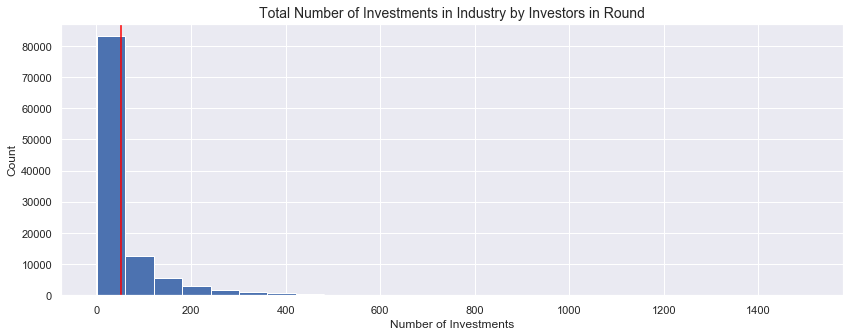

In [670]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_industry_investments_total.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_industry_investments_total']), color='red')
_ = plt.title('Total Number of Investments in Industry by Investors in Round', size=14)
_ = plt.xlabel('Number of Investments')
_ = plt.ylabel('Count')

### k) Max Investor Industry Investment Count

In [671]:
# Groupby Funding permalink to get investor category max total.
investor_industry_investment_max = fund_round_investor_category_count.groupby('funding_round_permalink')[['category_count']].max().reset_index()
investor_industry_investment_max.columns = ['funding_round_permalink','investor_industry_investments_max']

# Merge with investor industry investment max
investor_data = investor_data.merge(investor_industry_investment_max, how='left')
investor_data.shape

(163707, 16)

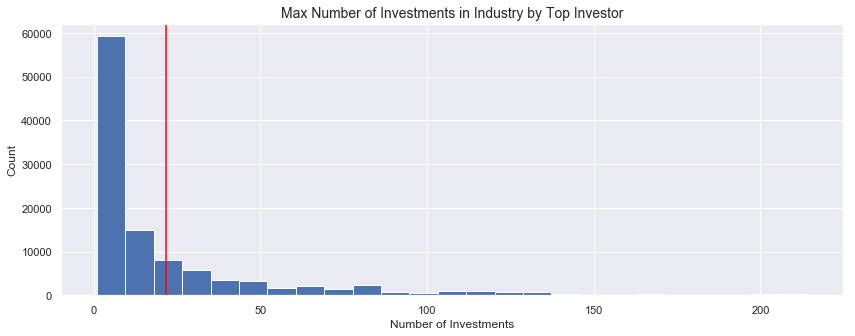

In [672]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_industry_investments_max.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_industry_investments_max']), color='red')
_ = plt.title('Max Number of Investments in Industry by Top Investor', size=14)
_ = plt.xlabel('Number of Investments')
_ = plt.ylabel('Count')

### l) Max Investor Industry Investment Percent

In [673]:
# Calculate Max Investment Percentage: Investor industry investment max / investor industry investment total
investor_data['investor_industry_investments_max_pct'] = investor_data['investor_industry_investments_max'] / investor_data['investor_industry_investments_total']
investor_data.shape

(163707, 17)

In [674]:
investor_data[['company_permalink','funding_round_permalink','investor_industry_investments_total','investor_industry_investments_max','investor_industry_investments_max_pct']].head()

,company_permalink,funding_round_permalink,investor_industry_investments_total,investor_industry_investments_max,investor_industry_investments_max_pct
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,2.0,2.0,1.000000
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,2.0,2.0,1.000000
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,5.0,5.0,1.000000
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,24.0,20.0,0.833333
4,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,24.0,20.0,0.833333


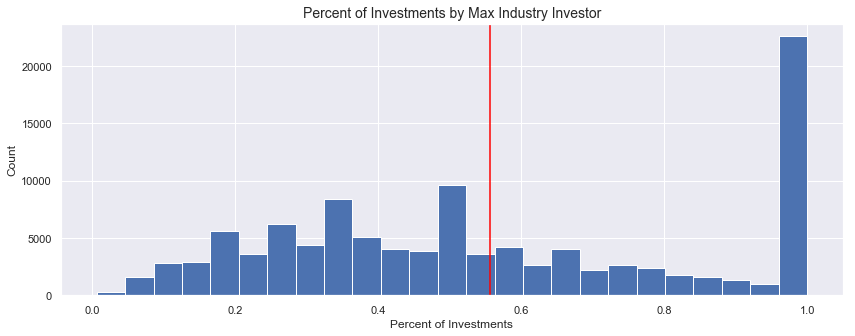

In [675]:
_ = plt.figure(figsize=(14,5))
_ = investor_data.investor_industry_investments_max_pct.hist(bins=25)
_ = plt.axvline(np.mean(investor_data['investor_industry_investments_max_pct']), color='red')
_ = plt.title('Percent of Investments by Max Industry Investor', size=14)
_ = plt.xlabel('Percent of Investments')
_ = plt.ylabel('Count')

### Clean

In [676]:
# Drop Redundant data points
final_investor_data = investor_data.drop(columns=['funding_round_type','funding_round_code','funded_at','raised_amount_usd']).drop_duplicates().fillna(0)

In [677]:
final_investor_data.shape

(162469, 13)

In [678]:
final_investor_data.head()

,company_permalink,funding_round_permalink,investor_company_same_country,round_investor_count,investor_investments_total_count,investor_investments_max_count,investor_investments_max_pct,investor_exits_total_count,investor_exits_max_count,investor_exits_max_pct,investor_industry_investments_total,investor_industry_investments_max,investor_industry_investments_max_pct
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,1,1,16.0,16.0,1.000000,2.0,2.0,1.0,2.0,2.0,1.000000
1,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,0,1,8.0,8.0,1.000000,2.0,2.0,1.0,2.0,2.0,1.000000
2,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,1,1,167.0,167.0,1.000000,0.0,0.0,0.0,5.0,5.0,1.000000
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,1,4,126.0,114.0,0.904762,10.0,7.0,0.7,24.0,20.0,0.833333
4,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,0,4,126.0,114.0,0.904762,10.0,7.0,0.7,24.0,20.0,0.833333


In [679]:
final_investor_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162469 entries, 0 to 163706
Data columns (total 13 columns):
company_permalink                        162469 non-null object
funding_round_permalink                  162469 non-null object
investor_company_same_country            162469 non-null int64
round_investor_count                     162469 non-null int64
investor_investments_total_count         162469 non-null float64
investor_investments_max_count           162469 non-null float64
investor_investments_max_pct             162469 non-null float64
investor_exits_total_count               162469 non-null float64
investor_exits_max_count                 162469 non-null float64
investor_exits_max_pct                   162469 non-null float64
investor_industry_investments_total      162469 non-null float64
investor_industry_investments_max        162469 non-null float64
investor_industry_investments_max_pct    162469 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usa

# 4. Macro Variables

### Using Funding Rounds Data

Macro data is divided into two datasets which will be overall data accumulating funding averages, totals, and count by year and also looking at individual round data by year over the same values

In [680]:
# Combine round type and round code to get complete list
investment_rounds['funding_round'] = investment_rounds.apply(get_round_name,axis=1)

# Get important columns
macro_raw_data = investment_rounds[['company_permalink','funding_round_permalink','funded_at','funding_round','funding_round_type','funding_round_code','raised_amount_usd']].drop_duplicates()

In [681]:
# Extract funding year and month data from funded_at
macro_raw_data['funded_year'] = macro_raw_data.funded_at.dt.year
macro_raw_data['funded_month'] = macro_raw_data.funded_at.dt.month

# Overall Macro

## a) Annual Average Funding (USD)

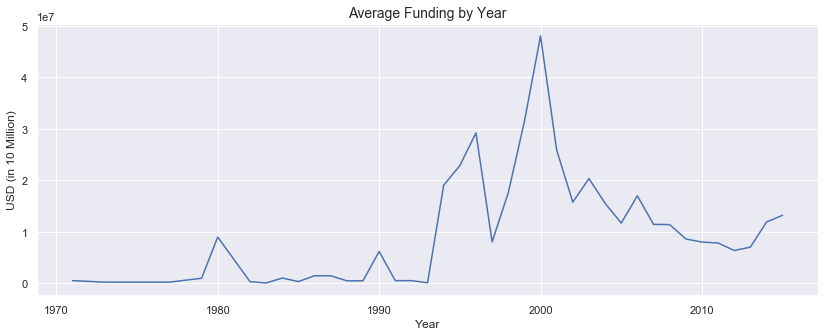

In [682]:
#Average by Year and get Avg Raised Amount
average_raised_amount = macro_raw_data.groupby(['funded_year'])[['raised_amount_usd']].mean().bfill()
average_raised_amount.columns = ['macro_annual_avrg_fund']

#Plot
_ = plt.figure(figsize=(14,5))
_ = plt.plot(average_raised_amount)
_ = plt.title('Average Funding by Year', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 10 Million)')

## b) Annual Funding Counts

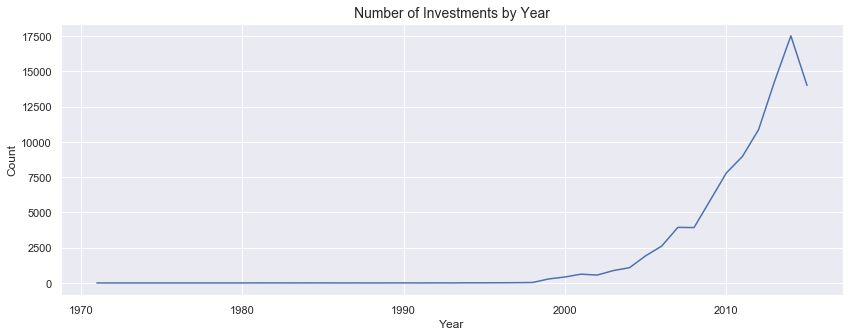

In [683]:
# Count by Year
count_raised_amount = macro_raw_data.groupby(['funded_year'])[['raised_amount_usd']].count()
count_raised_amount.columns = ['macro_annual_fund_count']

# Plot
_ = plt.figure(figsize=(14,5))
_ = plt.plot(count_raised_amount)
_ = plt.title('Number of Investments by Year', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('Count')

## c) Annual Funding Total (USD)

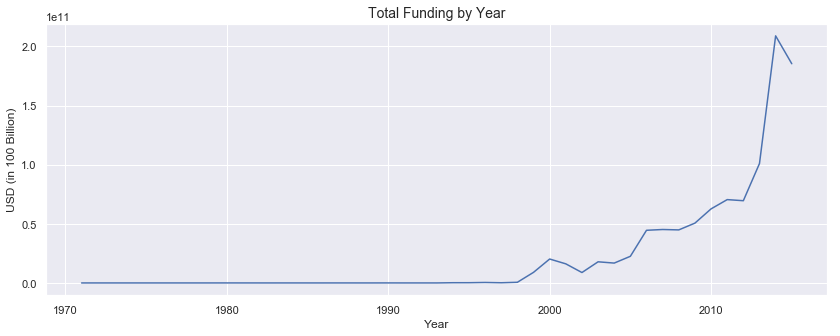

In [684]:
# Sum by Year to get total raised amounts 
total_raised_amount = macro_raw_data.groupby(['funded_year'])[['raised_amount_usd']].sum()
total_raised_amount.columns = ['macro_annual_total_fund']

# Plot
_ = plt.figure(figsize=(14,5))
_ = plt.plot(total_raised_amount)
_ = plt.title('Total Funding by Year', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Billion)')

In [685]:
#Reset Indexes for merging
average_raised_amount = average_raised_amount.reset_index()
count_raised_amount = count_raised_amount.reset_index()
total_raised_amount = total_raised_amount.reset_index()

#Merge
overall_macro_data = pd.merge(pd.merge(average_raised_amount, count_raised_amount), total_raised_amount)
overall_macro_data.columns = ['year','macro_annual_avrg_fund','macro_annual_fund_count','macro_annual_total_fund']

In [686]:
overall_macro_data.head()

,year,macro_annual_avrg_fund,macro_annual_fund_count,macro_annual_total_fund
0,1971,549000.0,1,549000.0
1,1973,250000.0,0,0.0
2,1977,250000.0,1,250000.0
3,1979,1000000.0,1,1000000.0
4,1980,9000000.0,1,9000000.0


### Acquisition Behavior

In [687]:
acquisitions['year'] = acquisitions['acquired_at'].dt.year
acquisitions['month'] = acquisitions['acquired_at'].dt.month
acquisitions['quarter'] = acquisitions.month.apply(month_to_quarter)

In [688]:
acquisition_count = acquisitions.groupby(['year'])[['company_permalink']].count().reset_index()
acquisition_count.columns = ['year','macro_acquisition_count']
acquisition_count.head()

,year,macro_acquisition_count
0,1960.0,1
1,1966.0,1
2,1967.0,1
3,1972.0,1
4,1973.0,1


In [689]:
overall_macro_data = overall_macro_data.merge(acquisition_count, how='left')
overall_macro_data.shape

(39, 5)

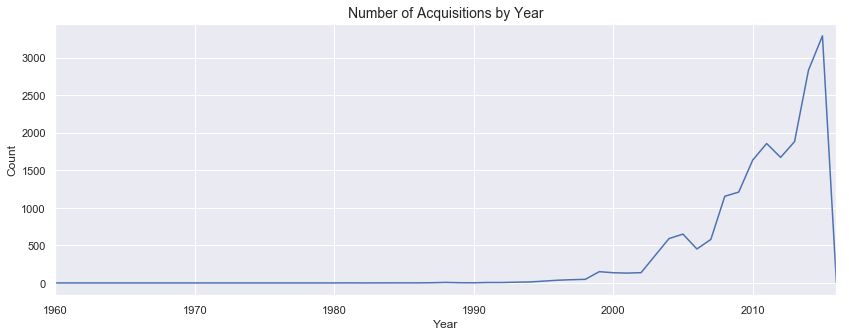

In [690]:
#Set index for Plot
acquisition_count_plot = acquisition_count.set_index('year')

#Plot
_ = plt.figure(figsize=(14,5))
_ = acquisition_count_plot['macro_acquisition_count'].plot()
_ = plt.title('Number of Acquisitions by Year', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('Count')

### IPO Behavior

In [691]:
ipos['year'] = ipos['public_at'].dt.year
ipos['month'] = ipos['public_at'].dt.month
ipos['quarter'] = ipos.month.apply(month_to_quarter)

In [692]:
ipo_counts = ipos.groupby(['year'])[['id']].count().reset_index()
ipo_counts.columns = ['year','macro_ipo_count']
ipo_counts.head(10)

,year,macro_ipo_count
0,1969.0,1
1,1971.0,1
2,1978.0,21
3,1979.0,1
4,1980.0,3
5,1981.0,2
6,1983.0,2
7,1984.0,1
8,1985.0,3
9,1986.0,7


In [693]:
overall_macro_data = overall_macro_data.merge(ipo_counts, how='left')
overall_macro_data.shape

(39, 6)

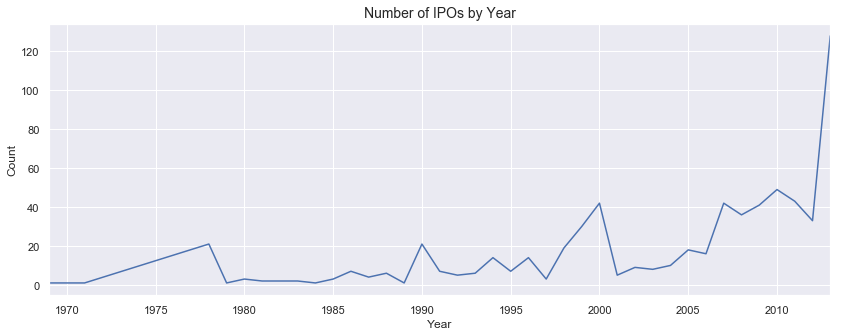

In [694]:
# Set year as index for plot
ipo_counts_plot = ipo_counts.set_index('year')

# Plot
_ = plt.figure(figsize=(14,5))
_ = ipo_counts_plot['macro_ipo_count'].plot()
_ = plt.title('Number of IPOs by Year', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('Count')

In [695]:
overall_macro_data['macro_acquisition_count'] = overall_macro_data['macro_acquisition_count'].fillna(0)
overall_macro_data['macro_ipo_count'] = overall_macro_data['macro_ipo_count'].fillna(0)

In [696]:
overall_macro_data.head()

,year,macro_annual_avrg_fund,macro_annual_fund_count,macro_annual_total_fund,macro_acquisition_count,macro_ipo_count
0,1971,549000.0,1,549000.0,0.0,1.0
1,1973,250000.0,0,0.0,1.0,0.0
2,1977,250000.0,1,250000.0,1.0,0.0
3,1979,1000000.0,1,1000000.0,0.0,1.0
4,1980,9000000.0,1,9000000.0,1.0,3.0


In [697]:
overall_macro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 38
Data columns (total 6 columns):
year                       39 non-null int64
macro_annual_avrg_fund     39 non-null float64
macro_annual_fund_count    39 non-null int64
macro_annual_total_fund    39 non-null float64
macro_acquisition_count    39 non-null float64
macro_ipo_count            39 non-null float64
dtypes: float64(4), int64(2)
memory usage: 2.1 KB


## b) By Round Type

In [698]:
# Average by year and round to get average amount raised by round by year
average_by_round_type = macro_raw_data.groupby(['funded_year','funding_round'])[['raised_amount_usd']].mean().fillna(0).reset_index()
average_by_round_type.columns = ['year','funding_round','macro_annual_avg_amt_round']

# Sum by year and round to get total amount raised by round by year
total_by_round_type = macro_raw_data.groupby(['funded_year','funding_round'])[['raised_amount_usd']].sum().reset_index()
total_by_round_type.columns = ['year','funding_round','macro_annual_ttl_amt_round']

# Count by year and round to get number of investments by round by year
count_by_round_type = macro_raw_data.groupby(['funded_year','funding_round'])[['raised_amount_usd']].count().reset_index()
count_by_round_type.columns = ['year','funding_round','macro_annual_cnt_amt_round']

In [699]:
# Merge round by year data to get full round macro data set
round_macro_data = pd.merge(pd.merge(average_by_round_type, total_by_round_type), count_by_round_type)

In [700]:
round_macro_data = round_macro_data.sort_values(['funding_round','year'])
round_macro_data.shape

(383, 5)

In [701]:
round_macro_data.head()

,year,funding_round,macro_annual_avg_amt_round,macro_annual_ttl_amt_round,macro_annual_cnt_amt_round
5,1982,A,3.480000e+05,1044000.0,3
7,1983,A,9.400000e+04,94000.0,1
8,1984,A,0.000000e+00,0.0,0
12,1985,A,3.593333e+05,1078000.0,3
16,1987,A,1.488000e+06,2976000.0,2


In [702]:
round_macro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 5 to 382
Data columns (total 5 columns):
year                          383 non-null int64
funding_round                 383 non-null object
macro_annual_avg_amt_round    383 non-null float64
macro_annual_ttl_amt_round    383 non-null float64
macro_annual_cnt_amt_round    383 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 18.0+ KB


In [703]:
# Split into two to make visualization more understandable.
venture_vals = ['venture','seed','angel','A','B','C','D','E','F','G','H']
other_vals = [x for x in round_macro_data.funding_round.unique() if x not in venture_vals]

# 
macro_venture = round_macro_data[round_macro_data.funding_round.isin(venture_vals)]
macro_other = round_macro_data[round_macro_data.funding_round.isin(other_vals)]

## Annual Average Amount Funded by Round

### Part 1) Venture

In [704]:
# Set up so columns are round types and index are years
avg_usd_round_year_venture = pd.pivot(index='year', columns='funding_round', values='macro_annual_avg_amt_round', data=macro_venture).fillna(0)

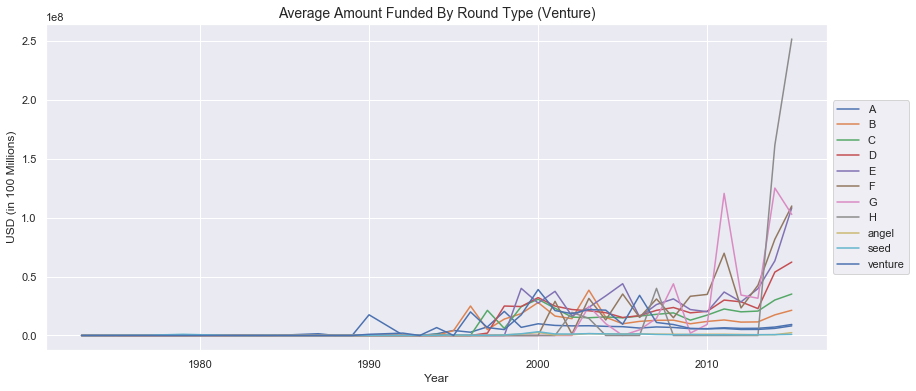

In [705]:
_ = plt.figure(figsize=(14,6))
_ = plt.plot(avg_usd_round_year_venture)
_ = plt.legend(avg_usd_round_year_venture.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Average Amount Funded By Round Type (Venture)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

### Part 2) Other

In [706]:
# Set up so columns are round types and index are years
avg_usd_round_year_other = pd.pivot(index='year', columns='funding_round', values='macro_annual_avg_amt_round', data=macro_other).fillna(0)

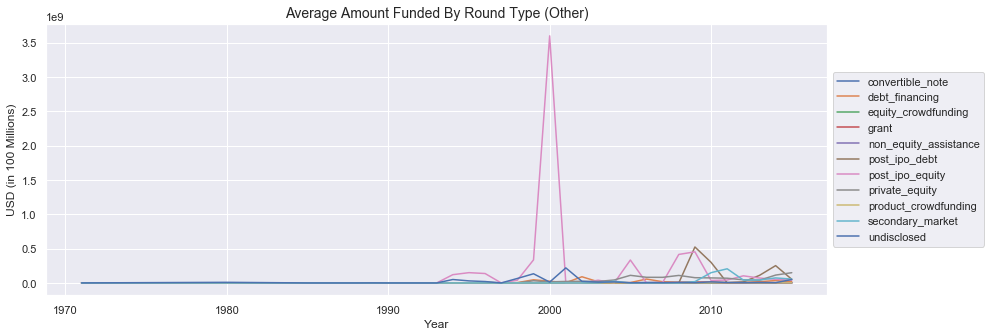

In [707]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(avg_usd_round_year_other)
_ = plt.legend(avg_usd_round_year_other.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Average Amount Funded By Round Type (Other)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

## g) Total Annual Amount Raised by Round

### Part 1) Venture

In [708]:
# Set up so columns are round types and index are years
ttl_usd_round_year_venture = pd.pivot(index='year', columns='funding_round', values='macro_annual_ttl_amt_round', data=macro_venture).fillna(0)

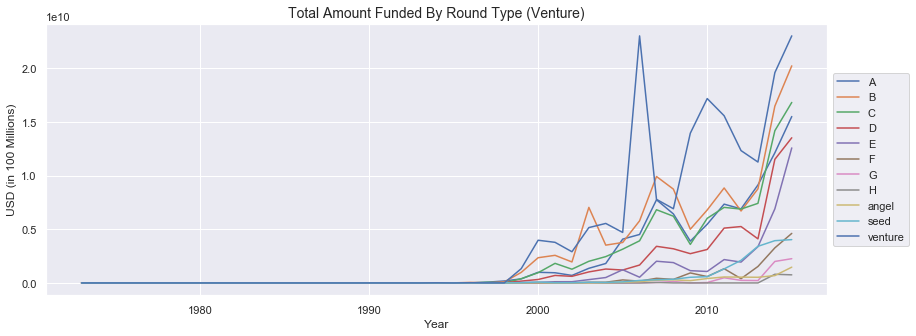

In [709]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(ttl_usd_round_year_venture)
_ = plt.legend(ttl_usd_round_year_venture.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Total Amount Funded By Round Type (Venture)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

### Part 2) Other

In [710]:
# Set up so columns are round types and index are years
ttl_usd_round_year_other = pd.pivot(index='year', columns='funding_round', values='macro_annual_ttl_amt_round', data=macro_other).fillna(0)

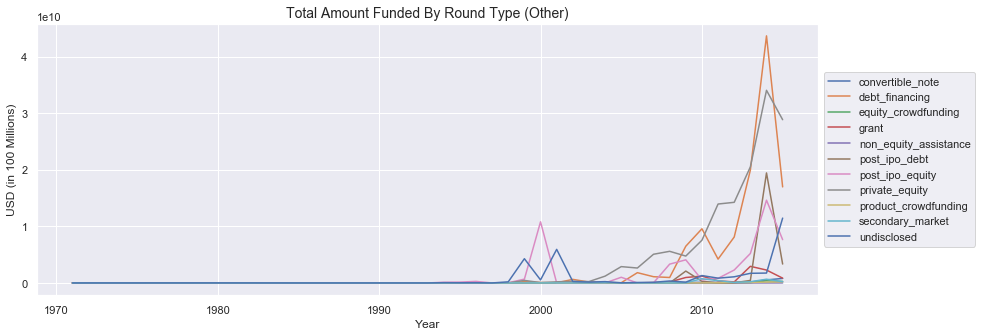

In [711]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(ttl_usd_round_year_other)
_ = plt.legend(ttl_usd_round_year_other.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Total Amount Funded By Round Type (Other)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

## h) Investment Count by Year by Round

### Part 1) Venture

In [712]:
# Set up so columns are round types and index are years
round_count_year_venture = pd.pivot(index='year', columns='funding_round', values='macro_annual_cnt_amt_round', data=macro_venture).fillna(0)

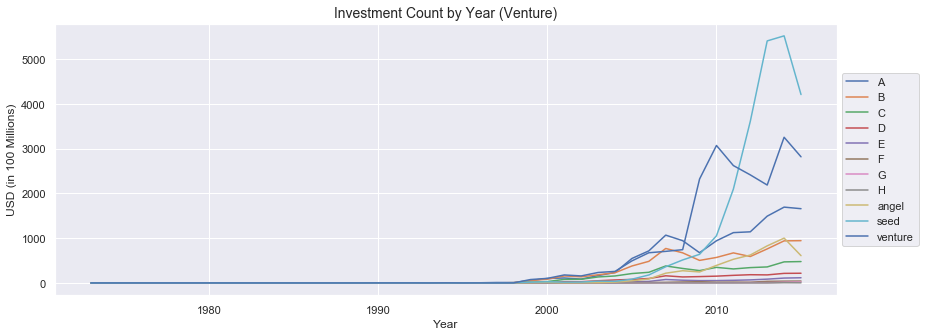

In [713]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(round_count_year_venture)
_ = plt.legend(round_count_year_venture.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Investment Count by Year (Venture)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

### Part 2) Other

In [714]:
# Set up so columns are round types and index are years
round_count_year_other = pd.pivot(index='year', columns='funding_round', values='macro_annual_cnt_amt_round', data=macro_other).fillna(0)

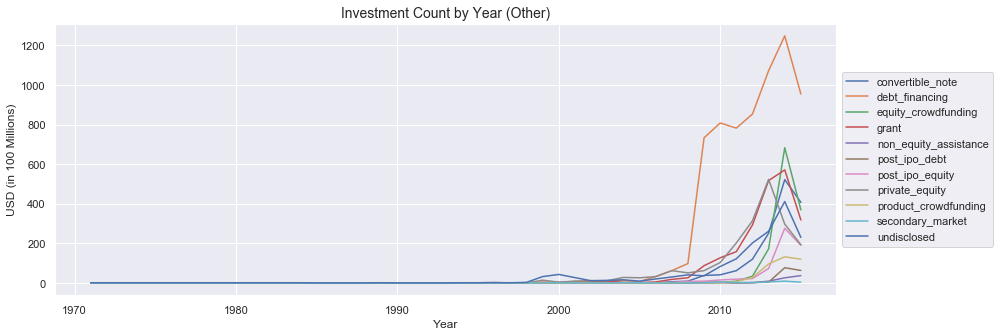

In [715]:
_ = plt.figure(figsize=(14,5))
_ = plt.plot(round_count_year_other)
_ = plt.legend(round_count_year_other.columns, loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.title('Investment Count by Year (Other)', size=14)
_ = plt.xlabel('Year')
_ = plt.ylabel('USD (in 100 Millions)')

# 6. Text Dummy Variables

The following variables will be turned into dummies:
- company_country_code
- investor_country_code
- funding_round_type
- funding_round_code

I chose to turn these to dummies as the have relatively low feature count.

In [716]:
# Columns used for Dummy Datasets
IDs = ['company_permalink','funding_round_permalink']
round_cols = ['funding_round_type','funding_round_code','prev_funding_round_type','prev_funding_round_code']
country_cols = ['company_country_code','investor_country_code']

# Get relevant columns from investment_rounds
round_dummy_data = final_funding_data[IDs + round_cols].drop_duplicates()
country_dummy_data = investment_rounds[IDs + country_cols].drop_duplicates()

In [717]:
# Use Company and Fund Permalink data as base
dummy_data = investment_rounds[['company_permalink','funding_round_permalink']].drop_duplicates()
dummy_data.shape

(114949, 2)

### a) Funding Round Type

In [718]:
# Create and merge Funding Round Type Dummies
funding_round_type_dummies = pd.get_dummies(round_dummy_data.funding_round_type)
round_type_dummies = round_dummy_data[IDs].merge(funding_round_type_dummies, right_index=True, left_index=True)
round_type_dummies.shape

(114948, 16)

In [719]:
dummy_data = dummy_data.merge(round_type_dummies, how='left')
dummy_data.shape

(114949, 16)

### b) Funding Round Code

In [720]:
# Create and merge Funding Round Type Dummies
funding_round_code_dummies = pd.get_dummies(round_dummy_data.funding_round_code)
round_code_dummies = round_dummy_data[IDs].merge(funding_round_code_dummies, right_index=True, left_index=True)
round_code_dummies.shape

(114948, 11)

In [721]:
dummy_data = dummy_data.merge(round_code_dummies, how='left')
dummy_data.shape

(114949, 25)

### c) Previous Funding Round Type

In [722]:
# Create Funding Round Type Dummies
prev_funding_round_type_dummies = pd.get_dummies(round_dummy_data.funding_round_type)

# Rename Columns Indicating Previous Round
prev_funding_round_type_dummies.columns = prev_funding_round_type_dummies.columns + '_prev'

#Merge with IDs
prev_round_type_dummies = round_dummy_data[IDs].merge(prev_funding_round_type_dummies, right_index=True, left_index=True)
prev_round_type_dummies.shape

(114948, 16)

In [723]:
dummy_data = dummy_data.merge(prev_round_type_dummies, how='left')
dummy_data.shape

(114949, 39)

### d) Previous Funding Round Code

In [724]:
# Create Funding Round Type Dummies
prev_funding_round_code_dummies = pd.get_dummies(round_dummy_data.prev_funding_round_code)

# Rename Columns Indicating Previous Round
prev_funding_round_code_dummies.columns = prev_funding_round_code_dummies.columns + '_prev'

#Merge with IDs
prev_round_code_dummies = round_dummy_data[IDs].merge(prev_funding_round_code_dummies, right_index=True, left_index=True)
prev_round_code_dummies.shape

(114948, 11)

In [725]:
dummy_data = dummy_data.merge(prev_round_code_dummies, how='left')
dummy_data.shape

(114949, 48)

### c) Company Country Code

In [726]:
# Full Company Country Code Dummies
company_country_code_dummies = pd.get_dummies(country_dummy_data.company_country_code)
company_country_code_dummies.columns = 'company_' + company_country_code_dummies.columns
company_country_code_dummies.shape

(141388, 137)

In [727]:
# Top 15 Countries Dummies
company_top_15_country_list = 'company_' + country_dummy_data.company_country_code.value_counts().head(15).index
company_top15_country_dummies = country_dummy_data[IDs].merge(company_country_code_dummies[company_top_15_country_list], left_index=True, right_index=True)
company_top15_country_dummies.shape

(141388, 17)

#### Merge

In [728]:
# Merge Top 15 Company Countries
dummy_data = dummy_data.merge(company_top15_country_dummies, how='left')
dummy_data.shape

(141388, 63)

### d) Investor Country Code

In [729]:
# Full Dummies
investor_country_code_dummies = pd.get_dummies(country_dummy_data.investor_country_code)
investor_country_code_dummies.columns = 'investor_' + investor_country_code_dummies.columns
investor_country_code_dummies.shape

(141388, 98)

In [730]:
# Merge with dummy data to get funding round for each investor country code row
investor_countries = country_dummy_data[IDs].merge(investor_country_code_dummies, right_index=True, left_index=True)

In [731]:
# Group by round to get all investor countries for round
investor_countries = investor_countries.groupby('funding_round_permalink').sum().reset_index()

In [732]:
# Top 15 Countries Dummies
investor_top_15_country_list = 'investor_' + country_dummy_data.investor_country_code.value_counts().head(15).index
investor_top15_company_country_dummies = investor_countries[['funding_round_permalink'] + list(investor_top_15_country_list)]
investor_top15_company_country_dummies.shape

(114949, 16)

#### Merge Top 15 Investor Country Code

In [733]:
# Merge Top 15 Investor Countries
dummy_data = dummy_data.merge(investor_top15_company_country_dummies, how='left')
dummy_data.shape

(141388, 78)

### Final Dummy Data

In [734]:
# Drop Redundant columns: Funding Round Type & Code, Company Country Code, and Investor Country Code
final_dummy_data = dummy_data.drop_duplicates()

In [735]:
final_dummy_data.shape

(114949, 78)

In [736]:
final_dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 141387
Data columns (total 78 columns):
company_permalink             114949 non-null object
funding_round_permalink       114949 non-null object
angel                         114948 non-null float64
convertible_note              114948 non-null float64
debt_financing                114948 non-null float64
equity_crowdfunding           114948 non-null float64
grant                         114948 non-null float64
non_equity_assistance         114948 non-null float64
post_ipo_debt                 114948 non-null float64
post_ipo_equity               114948 non-null float64
private_equity                114948 non-null float64
product_crowdfunding          114948 non-null float64
secondary_market              114948 non-null float64
seed                          114948 non-null float64
undisclosed                   114948 non-null float64
venture                       114948 non-null float64
A                          

# Target

The target variable for our machine learning model will be whether a company was funded within 1 year of a given date.  As you recall each row is a quarter in the lifecycle of the company since its first round.

To get this target I will take the funding date and identify all quarters up to 1 year prior to this date for each company.

### Get quarters up to one year prior to fund

In [737]:
# Will only need company, funding id, and funded date
target = investment_rounds[['company_permalink','funding_round_permalink','funded_at']]

# Date one year prior to getting funded
target['funded_in_one_year'] = target['funded_at'] - datetime.timedelta(days=365)

In [738]:
def months_to_fund(row):
    funded = row.funded_in_one_year
    next_funded = row.funded_at
    dates = []
    cur_date = funded
    
    while cur_date < next_funded:
        dates.append(cur_date)
        cur_date += relativedelta(months=1)
    return dates

#List of months 
target['all_dates'] = target.apply(months_to_fund, axis=1)

In [739]:
target_months_full = target['all_dates'].apply(pd.Series).merge(target[['company_permalink']], left_index=True, right_index=True)\
                    .melt(id_vars=['company_permalink']).dropna().drop(columns=['variable'])

#Rename Columns
target_months_full.columns = ['company_permalink','funded_in_one_year']

In [740]:
# Get Year and Month
target_months_full['year'] = target_months_full['funded_in_one_year'].dt.year
target_months_full['month'] = target_months_full['funded_in_one_year'].dt.month

#Month to Quarter
target_months_full['quarter'] = target_months_full['month'].apply(month_to_quarter)

# Binary mark dates
target_months_full['fund_within_year'] = 1

In [741]:
#
final_target = target_months_full[['company_permalink','year','quarter','fund_within_year']].drop_duplicates().sort_values(['company_permalink','year','quarter']).reset_index(drop=True)

In [742]:
final_target.shape

(466682, 4)

In [743]:
final_target.head(10)

,company_permalink,year,quarter,fund_within_year
0,/organization/-fame,2014,1,1
1,/organization/-fame,2014,2,1
2,/organization/-fame,2014,3,1
3,/organization/-fame,2014,4,1
4,/organization/-qounter,2013,1,1
5,/organization/-qounter,2013,2,1
6,/organization/-qounter,2013,3,1
7,/organization/-qounter,2013,4,1
8,/organization/-qounter,2014,1,1
9,/organization/-qounter,2014,2,1


# Finalize Dataset: Merge all sections together.
Merge the individual sections into one master data set.

In [744]:
final_master_data = master_data

In [745]:
final_master_data.head()

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1
2,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,3,2,2
3,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,4,3,3
4,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,1,0,0


In [746]:
final_master_data.shape

(1203049, 7)

### Add Company Data

In [747]:
final_company_data.head(3)

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round,short_description,company_category_list,company_category_count,founding_to_funding_months,founded_yr,founded_month,first_funding_yr,first_funding_month
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0,Fame is a live video entertainment platform th...,Media,1,36.0,2012.0,1.0,2015.0,1.0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1,Fame is a live video entertainment platform th...,Media,1,36.0,2012.0,1.0,2015.0,1.0
2,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,3,2,2,Fame is a live video entertainment platform th...,Media,1,36.0,2012.0,1.0,2015.0,1.0


In [748]:
#Add Company Data
final_master_data = final_master_data.merge(final_company_data.drop_duplicates().drop(columns=['company_id']), how='left')
final_master_data.shape

(1203049, 15)

In [749]:
final_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203049 entries, 0 to 1203048
Data columns (total 15 columns):
company_id                    1203049 non-null int64
company_permalink             1203049 non-null object
funding_round_permalink       1203049 non-null object
year                          1203049 non-null int64
quarter                       1203049 non-null int64
tenure_quarters_overall       1203049 non-null int64
tenure_quarters_round         1203049 non-null int64
short_description             1072375 non-null object
company_category_list         1142271 non-null object
company_category_count        1203045 non-null float64
founding_to_funding_months    1202845 non-null float64
founded_yr                    1203027 non-null float64
founded_month                 1203027 non-null float64
first_funding_yr              1202827 non-null float64
first_funding_month           1202827 non-null float64
dtypes: float64(6), int64(5), object(4)
memory usage: 146.9+ MB


### Add Funding Data

In [808]:
#Drop Cols 
final_funding_data.head()

,company_permalink,funding_round_permalink,round_number,funding_round,funding_round_type,funding_round_code,raised_amount_usd,total_funding_usd,prev_raised_amount_usd,prev_round_number,prev_funding_round_type,prev_funding_round_code
0,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,1,A,venture,A,2000000.0,2000000.0,0.0,0.0,no_prev_round,NaN
1,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,1,undisclosed,undisclosed,NaN,41250.0,41250.0,0.0,0.0,no_prev_round,NaN
2,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,4,B,venture,B,20000000.0,33600000.0,8900000.0,3.0,venture,A
3,/organization/0xdata,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,2,seed,seed,NaN,3000000.0,4700000.0,1700000.0,1.0,venture,Unknown
4,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,1,Unknown,venture,Unknown,1700000.0,1700000.0,0.0,0.0,no_prev_round,NaN


In [809]:
final_funding_data.shape

(115731, 12)

In [810]:
final_funding_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115731 entries, 0 to 115730
Data columns (total 12 columns):
company_permalink          115731 non-null object
funding_round_permalink    115731 non-null object
round_number               115731 non-null int64
funding_round              115731 non-null object
funding_round_type         115731 non-null object
funding_round_code         56004 non-null object
raised_amount_usd          98709 non-null float64
total_funding_usd          93929 non-null float64
prev_raised_amount_usd     115731 non-null float64
prev_round_number          115731 non-null float64
prev_funding_round_type    115731 non-null object
prev_funding_round_code    26066 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 11.5+ MB


In [753]:
final_master_data = final_master_data.merge(final_funding_data.drop_duplicates(), how='left')
final_master_data.shape

(1209929, 25)

In [754]:
final_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209929 entries, 0 to 1209928
Data columns (total 25 columns):
company_id                    1209929 non-null int64
company_permalink             1209929 non-null object
funding_round_permalink       1209929 non-null object
year                          1209929 non-null int64
quarter                       1209929 non-null int64
tenure_quarters_overall       1209929 non-null int64
tenure_quarters_round         1209929 non-null int64
short_description             1078395 non-null object
company_category_list         1148263 non-null object
company_category_count        1209925 non-null float64
founding_to_funding_months    1209723 non-null float64
founded_yr                    1209907 non-null float64
founded_month                 1209907 non-null float64
first_funding_yr              1209705 non-null float64
first_funding_month           1209705 non-null float64
round_number                  1209925 non-null float64
funding_round        

### Add Investor Data

In [755]:
final_investor_data.shape

(162469, 13)

In [756]:
final_investor_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162469 entries, 0 to 163706
Data columns (total 13 columns):
company_permalink                        162469 non-null object
funding_round_permalink                  162469 non-null object
investor_company_same_country            162469 non-null int64
round_investor_count                     162469 non-null int64
investor_investments_total_count         162469 non-null float64
investor_investments_max_count           162469 non-null float64
investor_investments_max_pct             162469 non-null float64
investor_exits_total_count               162469 non-null float64
investor_exits_max_count                 162469 non-null float64
investor_exits_max_pct                   162469 non-null float64
investor_industry_investments_total      162469 non-null float64
investor_industry_investments_max        162469 non-null float64
investor_industry_investments_max_pct    162469 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usa

In [757]:
# Merge Investor Data to Master
final_master_data = final_master_data.merge(final_investor_data.drop_duplicates(), how='left')
final_master_data.shape
#Shape increases as some rounds contained different types of investors

(1587109, 36)

In [758]:
final_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587109 entries, 0 to 1587108
Data columns (total 36 columns):
company_id                               1587109 non-null int64
company_permalink                        1587109 non-null object
funding_round_permalink                  1587109 non-null object
year                                     1587109 non-null int64
quarter                                  1587109 non-null int64
tenure_quarters_overall                  1587109 non-null int64
tenure_quarters_round                    1587109 non-null int64
short_description                        1425176 non-null object
company_category_list                    1521454 non-null object
company_category_count                   1587105 non-null float64
founding_to_funding_months               1586869 non-null float64
founded_yr                               1587075 non-null float64
founded_month                            1587075 non-null float64
first_funding_yr                         15

## Add Overall Macro Data

In [759]:
overall_macro_data.shape

(39, 6)

In [760]:
overall_macro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 38
Data columns (total 6 columns):
year                       39 non-null int64
macro_annual_avrg_fund     39 non-null float64
macro_annual_fund_count    39 non-null int64
macro_annual_total_fund    39 non-null float64
macro_acquisition_count    39 non-null float64
macro_ipo_count            39 non-null float64
dtypes: float64(4), int64(2)
memory usage: 2.1 KB


In [761]:
final_master_data = final_master_data.merge(overall_macro_data.drop_duplicates(), how='left')
final_master_data.shape

(1587109, 41)

## Add Round Macro Data

In [762]:
round_macro_data.shape

(383, 5)

In [763]:
round_macro_data.head()

,year,funding_round,macro_annual_avg_amt_round,macro_annual_ttl_amt_round,macro_annual_cnt_amt_round
5,1982,A,3.480000e+05,1044000.0,3
7,1983,A,9.400000e+04,94000.0,1
8,1984,A,0.000000e+00,0.0,0
12,1985,A,3.593333e+05,1078000.0,3
16,1987,A,1.488000e+06,2976000.0,2


In [764]:
round_macro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 5 to 382
Data columns (total 5 columns):
year                          383 non-null int64
funding_round                 383 non-null object
macro_annual_avg_amt_round    383 non-null float64
macro_annual_ttl_amt_round    383 non-null float64
macro_annual_cnt_amt_round    383 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 18.0+ KB


In [765]:
final_master_data = final_master_data.merge(round_macro_data.drop_duplicates(), how='left')
final_master_data.shape

(1587109, 44)

## Add Dummy Data

In [766]:
final_dummy_data.shape

(114949, 78)

In [767]:
final_master_data = final_master_data.merge(final_dummy_data.drop_duplicates(), how='left')

In [768]:
final_master_data.shape

(1587109, 120)

## Add Target Variable

In [769]:
final_target.head()

,company_permalink,year,quarter,fund_within_year
0,/organization/-fame,2014,1,1
1,/organization/-fame,2014,2,1
2,/organization/-fame,2014,3,1
3,/organization/-fame,2014,4,1
4,/organization/-qounter,2013,1,1


In [770]:
# This will reduce as this set includes year previous from first round
final_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466682 entries, 0 to 466681
Data columns (total 4 columns):
company_permalink    466682 non-null object
year                 466682 non-null int64
quarter              466682 non-null int64
fund_within_year     466682 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.2+ MB


In [771]:
final_master_data = final_master_data.merge(final_target, how='left')

In [772]:
#Fill non fund_within_year values with 0 for binary output
final_master_data['fund_within_year'] = final_master_data['fund_within_year'].fillna(0)

In [773]:
#
final_master_data = final_master_data[(final_master_data.post_ipo_debt != 1) & (final_master_data.post_ipo_equity != 1)]

In [774]:
final_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581389 entries, 0 to 1587108
Columns: 121 entries, company_id to fund_within_year
dtypes: float64(75), int64(7), object(9), uint8(30)
memory usage: 1.1+ GB


### Export Final Data Frame

In [775]:
final_master_data.shape

(1581389, 121)

In [776]:
final_master_data.head()

,company_id,company_permalink,funding_round_permalink,year,quarter,tenure_quarters_overall,tenure_quarters_round,short_description,company_category_list,company_category_count,...,investor_ESP,investor_ISR,investor_CHE,investor_JPN,investor_IND,investor_HKG,investor_SGP,investor_CHL,investor_SWE,fund_within_year
0,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,1,0,0,Fame is a live video entertainment platform th...,Media,1.0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,2,1,1,Fame is a live video entertainment platform th...,Media,1.0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,3,2,2,Fame is a live video entertainment platform th...,Media,1.0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,2015,4,3,3,Fame is a live video entertainment platform th...,Media,1.0,...,0,0,0,0,0,0,0,0,0,0.0
4,1,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,2014,1,0,0,"Disruptive Social Cash back platform. Earn, sh...",Application Platforms|Real Time|Social Network...,3.0,...,0,0,0,0,0,0,0,0,0,1.0


In [777]:
final_master_data.to_csv('data/processed/crunchbase_data.csv')